In [145]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from GIF import createDir, createGif
import random as rnd
import seaborn as sns

In [167]:
plt.rcParams['figure.figsize'] = [26, 20]  # changing parameters for presented plots
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [112]:
def dist(A, B):
    return np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)


class Agent:
    def __init__(self, pos, road_info, alpha_par, beta_par, gamma_par, stubborn = False):
        self.pos = pos
        self.S = 0
        self.S_prev = 0
        self.X = 0
        self.K = 0
        self.global_ = 0
        self.social = 0
        self.neighbour = 0
        self.I = 0
        #self.alpha = np.random.normal(*alpha_par)
        self.alpha = alpha_par
        #self.beta  = np.random.normal(*beta_par)
        self.beta  = 1-self.alpha
        #self.gamma = np.random.normal(*gamma_par)
        self.gamma = 1-self.alpha
        self.theta = np.random.normal(0.5, 0.1)
        self.p_par = (0.1, 0.1)
        self.tau   = np.random.uniform(0.1, 0.9)
        self.road = (road_info[0], road_info[1], road_info[2], road_info[3])
        self.v = 0
        self.v_max = 5
        self.plot = True
        self.move_pos = self.pos
        self.next_road = self.road
        self.color = (np.random.uniform(0.1,1), np.random.uniform(0.1,1), np.random.uniform(0.1,1))
        self.stubborn = stubborn


    def choose_update(self):
        if self.stubborn == False:
            p_update = np.random.normal(*self.p_par)
            # p_update = 0.1
            if np.random.random() < p_update:
                return True
            else:
                return False
        else:
            return False

    def global_opinion(self):
        self.global_ = 1

    def social_opinion(self, agents):
        influence_count = 0

        d_max = 0
        distances = {}
        for agent in agents:
            d = dist(self.pos, agent.pos)
            distances[agent] = d
            if d > d_max:
                d_max = d

        weights = {}
        for agent in agents:
            if agent != self:
                p = 1 - distances[agent] / (d_max + 1)
                if np.random.random() < p:
                    weights[agent] = 1
                    influence_count += 1
        for agent in weights:
            weights[agent] /= influence_count

        social_ = 0
        for agent in weights:
            social_ += weights[agent]*agent.S_prev
        self.social = social_

    def neighbour_opinion(self):
        num_of_neighbours = len(self.road[0])
        neighbour_ = 0
        for neighbour in self.road[0]:
            if self != neighbour:
                neighbour_ += 1 / num_of_neighbours * neighbour.X
        self.neighbour = neighbour_

    def overall_opinion(self):
        self.I = self.global_ * self.alpha + self.social * self.beta + self.neighbour * self.gamma

    def calc_S(self):
        if (1 - self.S) > 0.0001:
            next_S_prev = self.S
            self.S = self.S + self.theta * (self.I - self.S)
            self.S_prev = next_S_prev

    def decide(self):
        if self.stubborn == False:
            if self.X == 0:
                if self.S >= self.tau:
                    self.X = 1
                    self.K = 1

    def calc_move(self):
        if self.X == 1:
            if self.v < self.v_max:
                self.v += 1
            if (self.road[2] == '_' and self.pos[0] == list(self.road[1].keys())[-1][0]) or (self.road[2] == '|' and self.pos[1] == list(self.road[1].keys())[-1][1]):
                # print(self.pos,list(self.road[1].keys())[-1],self.road[3])
                if self.road[3] in [23, 20]:
                    self.K = 2
                    self.X = 2
                    self.road[0].remove(self)
                    self.road[1][self.pos].remove(self)
                    self.plot = False

                elif self.road[2] == '_':
                    allowed_move = 1
                    if self.road[3] not in [0, 1, 2]:
                        allowed_move = 0
                        right_hand_road = roads[self.road[3] - 3]
                        if list(right_hand_road[1].values())[-1] == []:
                            allowed_move = 1
                    if allowed_move == 1:
                        if self.road[3] in [2, 9, 16]:
                            upper_road = roads[self.road[3] + 4]
                            max_travel = 0
                            break_val = 0 
                            for i in range(1,self.v+1):
                                new_pos = (self.pos[0] + 1, self.pos[1] + 1 + i)
                                if upper_road[1][new_pos] != []:
                                    for i in upper_road[1][new_pos]:
                                        if i.X == 1:
                                            self.v = 0
                                            break_val = 1
                                    if break_val == 1:
                                        break
                                else:
                                    max_travel += 1
                            if max_travel == 0:
                                self.move_pos = self.pos
                            else:
                                self.move_pos = (self.pos[0] + 1, self.pos[1] + max_travel)
                                self.next_road = upper_road
                        elif self.road[3] in [21, 22]:
                            right_road = roads[self.road[3] + 1]
                            max_travel = 0
                            break_val = 0 
                            for i in range(1,self.v+1):
                                new_pos = (self.pos[0] + 1 + i, self.pos[1])
                                if right_road[1][new_pos] != []:
                                    for i in right_road[1][new_pos]:
                                        if i.X == 1:
                                            self.v = 0
                                            break_val = 1
                                            break
                                    if break_val == 1:
                                        break       
                                else:
                                    max_travel += 1
                            if max_travel == 0:
                                self.move_pos = self.pos
                            else:
                                self.move_pos = (self.pos[0] + 1 + max_travel, self.pos[1])
                                self.next_road = right_road
                        else:
                            if np.random.random() < 0.5:
                                right_road = roads[self.road[3] + 1]
                                max_travel = 0
                                break_val = 0
                                for i in range(1, self.v + 1):
                                    new_pos = (self.pos[0] + 1 + i, self.pos[1])
                                    if right_road[1][new_pos] != []:
                                        for i in right_road[1][new_pos]:
                                            if i.X == 1:
                                                self.v = 0
                                                break_val = 1
                                                break
                                        if break_val == 1:
                                            break
                                    else:
                                        max_travel += 1
                                if max_travel == 0:
                                    self.v = 0
                                    self.K = 0
                                else:
                                    self.move_pos = (self.pos[0] + 1 + max_travel, self.pos[1])
                                    self.next_road = right_road
                            else:
                                upper_road = roads[self.road[3] + 4]
                                max_travel = 0
                                break_val = 0
                                for i in range(1,self.v+1):
                                    new_pos = (self.pos[0] + 1, self.pos[1] + i)
                                    if upper_road[1][new_pos] != []:
                                        for i in upper_road[1][new_pos]:
                                            if i.X == 1:
                                                self.v = 0
                                                break_val = 1
                                                break
                                        if break_val == 1:
                                            break
                                    else:
                                        max_travel += 1
                                if max_travel == 0:
                                    self.move_pos = self.pos
                                    self.v = 0
                                    self.K = 0
                                else:
                                    self.move_pos = (self.pos[0] + 1, self.pos[1] + max_travel)
                                    self.next_road = upper_road

                elif self.road[2] == '|':
                    if  self.road[3] in [17, 18, 19]:
                        right_road = roads[self.road[3] + 4]
                        max_travel = 0
                        break_val = 0
                        for i in range(1,self.v+1):
                            new_pos = (self.pos[0] + i, self.pos[1] + 1)
                            if right_road[1][new_pos] != []:
                                for i in right_road[1][new_pos]:
                                    if i.X == 1:
                                        self.v = 0
                                        break_val = 1
                                        break
                                if break_val == 1:
                                    break
                            else:
                                max_travel += 1
                        if max_travel == 0:
                            self.move_pos = self.pos
                        else:
                            self.move_pos = (self.pos[0] + max_travel, self.pos[1] + 1)
                            self.next_road = right_road
                    elif self.road[3] in [6, 13]:
                        upper_road = roads[self.road[3] + 7]
                        max_travel = 0
                        break_val = 0
                        for i in range(1, self.v + 1):
                            new_pos = (self.pos[0], self.pos[1] + 1 + i)
                            if upper_road[1][new_pos] != []:
                                for i in upper_road[1][new_pos]:
                                    if i.X == 1:
                                        self.v = 0
                                        break_val = 1
                                        break
                                if break_val == 1:
                                    break
                            else:
                                max_travel += 1
                        if max_travel == 0:
                            self.move_pos = self.pos
                        else:
                            self.move_pos = (self.pos[0], self.pos[1] + 1 + max_travel)
                            self.next_road = upper_road
                    else:
                        if np.random.random() < 0.5:
                            right_road = roads[self.road[3] + 4]
                            max_travel = 0
                            break_val = 0
                            for i in range(1,self.v+1):
                                new_pos = (self.pos[0] + i, self.pos[1] + 1)
                                if right_road[1][new_pos] != []:
                                    for i in right_road[1][new_pos]:
                                        if i.X == 1:
                                            self.v = 0
                                            break_val = 1
                                            break
                                    if break_val == 1:
                                        break
                                else:
                                    max_travel += 1
                            if max_travel == 0:
                                self.move_pos = self.pos
                            else:
                                self.move_pos = (self.pos[0] + max_travel, self.pos[1] + 1)
                                self.next_road = right_road
                        else:
                            upper_road = roads[self.road[3] + 7]
                            max_travel = 0
                            break_val = 0
                            for i in range(1,self.v + 1):
                                new_pos = (self.pos[0], self.pos[1] + 1 + i)
                                if upper_road[1][new_pos] != []:
                                    for i in upper_road[1][new_pos]:
                                        if i.X == 1:
                                            self.v = 0
                                            self.K = 0
                                            break_val = 1
                                            break
                                    if break_val == 1:
                                        break
                                else:
                                    max_travel += 1
                            if max_travel == 0:
                                self.move_pos = self.pos
                                self.v = 0
                                self.K = 0
                            else:
                                self.move_pos = (self.pos[0], self.pos[1] + 1 + max_travel)
                                self.next_road = upper_road
            else:
                if self.road[2] == '_':
                    max_travel = 0
                    break_val = 0
                    for i in range(1,self.v + 1):
                        new_pos = (self.pos[0] + i, self.pos[1])
                        if new_pos not in self.road[1].keys():
                            self.v = 0
                            break
                        elif self.road[1][new_pos] != []:
                            for i in self.road[1][new_pos]:
                                if i.X == 1:
                                    self.v = 0
                                    break_val = 1
                                    break
                            if break_val == 1:
                                break
                        else:
                            max_travel += 1
                    self.move_pos = (self.pos[0] + max_travel, self.pos[1])
                    if max_travel>= 0:
                        self.K = 1
                elif self.road[2] == '|':
                    max_travel = 0
                    break_val = 0
                    for i in range(1,self.v + 1):
                        new_pos = (self.pos[0], self.pos[1] + i)
                        if new_pos not in self.road[1].keys():
                            self.v = 0
                            break
                        elif self.road[1][new_pos] != []:
                            for i in self.road[1][new_pos]:
                                if i.X == 1:
                                    self.v = 0
                                    break_val = 1
                                    break
                            if break_val == 1:
                                break
                        else:
                            max_travel += 1
                    self.move_pos = (self.pos[0], self.pos[1] + max_travel)
                    if max_travel>= 0:
                        self.K = 1
                    

    def move(self):
        if self.X == 1:
            self.road[0].remove(self)
            self.road[1][self.pos].remove(self)
            self.pos = self.move_pos
            self.road = self.next_road
            self.road[0].append(self)
            self.road[1][self.pos].append(self)


In [186]:
MC = 10
N=10
T = 300
alpha = np.random.normal(0.5,0.1)
beta = 0
gamma = 1-alpha
percent = 0
k0_list = np.zeros(T+1)
k0_list[0] = 1
k1_list = np.zeros(T+1)
k2_list = np.zeros(T+1)
N = 10
k_matrix = np.zeros([240, T+1])

S_mean = np.zeros(T+1)
S_std = np.zeros(T+1)

dir = createDir('TEST') 
k2_list_general = []

for m in range(MC):
    roads = []
    for j in range(3):
        roads.append(([], {(i, j * 101): [] for i in range(1, 101)}, '_'))
        roads.append(([], {(i, j * 101): [] for i in range(102, 202)}, '_'))
        roads.append(([], {(i, j * 101): [] for i in range(203, 303)}, '_'))

        roads.append(([], {(0, i): [] for i in range((j) * 101 + 1, (j + 1) * 101)}, '|'))
        roads.append(([], {(101, i): [] for i in range((j) * 101 + 1, (j + 1) * 101)}, '|'))
        roads.append(([], {(202, i): [] for i in range((j) * 101 + 1, (j + 1) * 101)}, '|'))
        roads.append(([], {(303, i): [] for i in range((j) * 101 + 1, (j + 1) * 101)}, '|'))
    roads.append(([], {(i, 303): [] for i in range(1, 101)}, '_'))
    roads.append(([], {(i, 303): [] for i in range(102, 202)}, '_'))
    roads.append(([], {(i, 303): [] for i in range(203, 303)}, '_'))

    for i in range(len(roads)):
        roads[i] = roads[i] + (i,)

    agents = []
    for road in roads:
        if road[2] == '_':
            for i in range(N):
                agent = Agent((list(road[1].keys())[0][0] + 4 + 10 * i, list(road[1].keys())[0][1]), road,alpha_par = alpha, beta_par = beta, gamma_par = gamma)
                agents.append(agent)
                road[0].append(agent)
                road[1][agent.pos].append(agent)
        else:
            for i in range(N):
                agent = Agent((list(road[1].keys())[0][0], list(road[1].keys())[0][1] + 4 + 10 * i), road,alpha_par = alpha, beta_par = beta, gamma_par = gamma)
                agents.append(agent)
                road[0].append(agent)
                road[1][agent.pos].append(agent)

    stubborn_agents = rnd.sample(agents, int(len(agents)*percent/100))
    for i in stubborn_agents:
        i.stubborn = True
        i.color = (0,0,0)
    S_matrix = np.zeros([240, T + 1])
    for i in range(1, T + 1):
        k0_counter = 0
        k1_counter = 0
        k2_counter = 0
        for j, agent in enumerate(agents):
            S_matrix[j, i] += agent.S
            if agent.X == 0:
                k0_counter += 1
            elif agent.X == 1:
                k1_counter += 1
                if m == 0:
                    k_matrix[j,i] = 1
            elif agent.X == 2:
                k2_counter += 1
                if m == 0:
                    k_matrix[j,i] = 2
            if agent.choose_update():
                agent.global_opinion()
                #agent.social_opinion(agents)
                agent.neighbour_opinion()
            agent.overall_opinion()
            agent.calc_S()
            agent.decide()
            agent.calc_move()
        k0_list[i] += k0_counter / 240 / MC
        k1_list[i] += k1_counter / 240 / MC
        k2_list[i] += k2_counter / 240 / MC


        #for road in roads:
         #   list_road = list(road[1].keys())
          #  plt.plot([list_road[0][0], list_road[-1][0]], [list_road[0][1], list_road[-1][1]], color='grey', linewidth=2,
           #           zorder=1)
        #plt.scatter(303, 303, color='red')
        for agent in agents:
         #   if agent.plot == True:
          #      plt.scatter(agent.pos[0], agent.pos[1], c = [agent.color], zorder = 3)
            agent.move()
        #plt.savefig(dir + f't = {i}.png')
        #plt.clf()
    S_mean += np.mean(S_matrix, axis = 0) / MC
    S_std  += np.std(S_matrix,  axis = 0) / MC



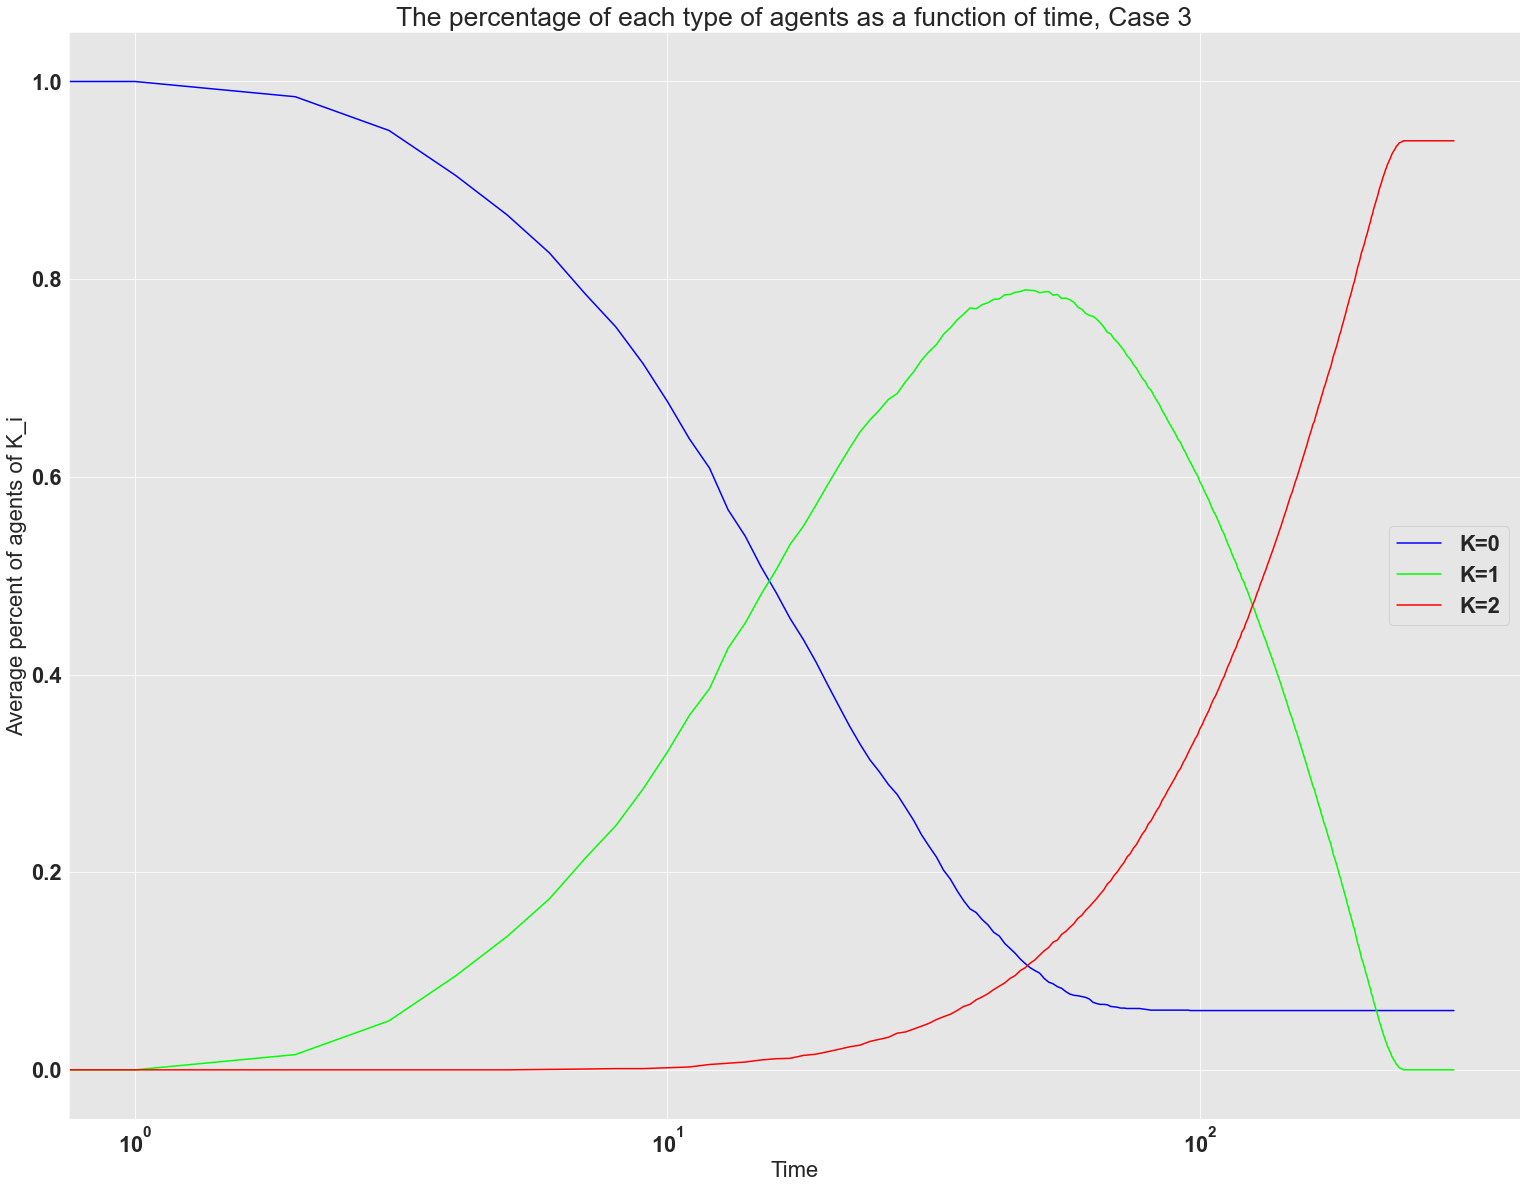

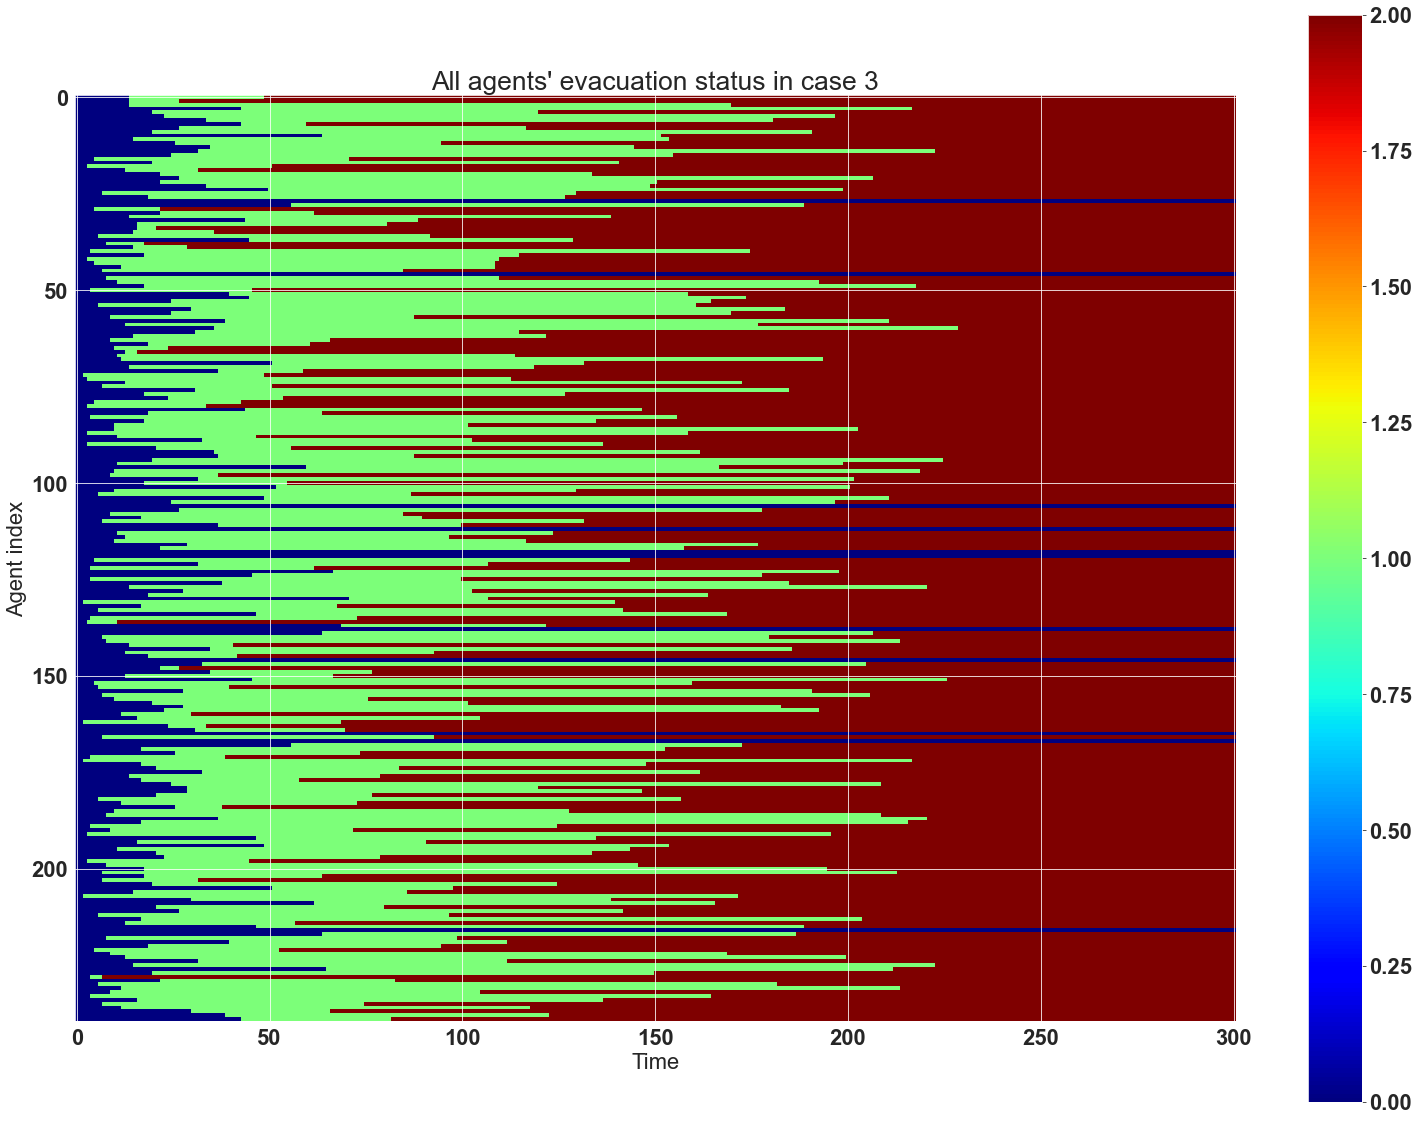

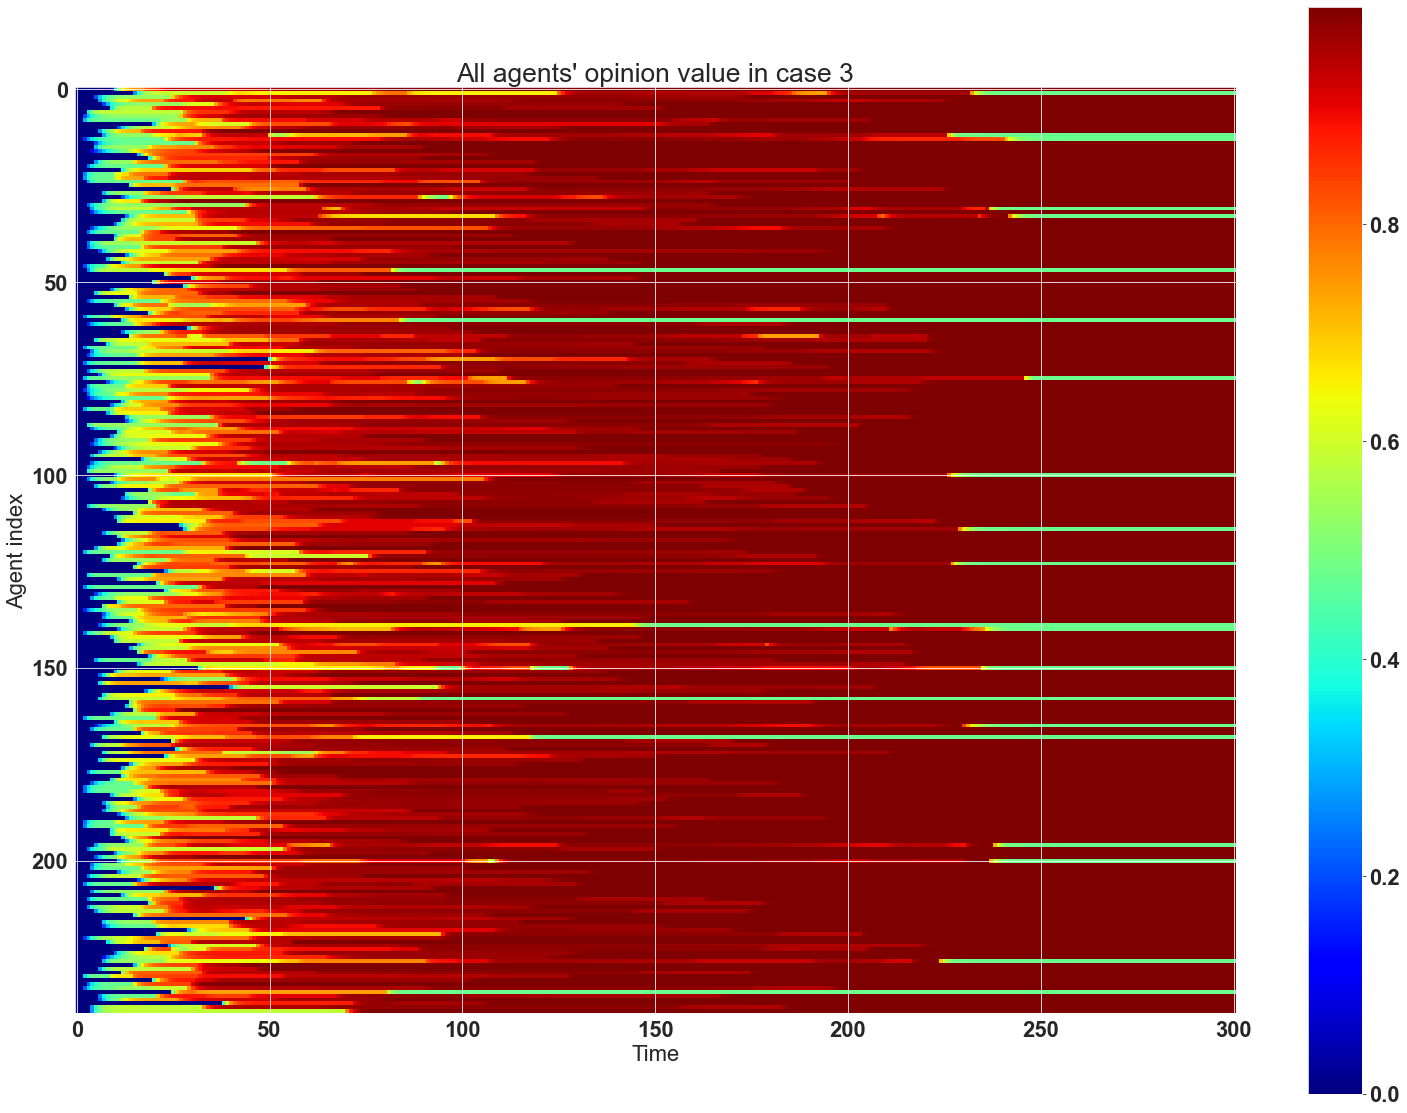

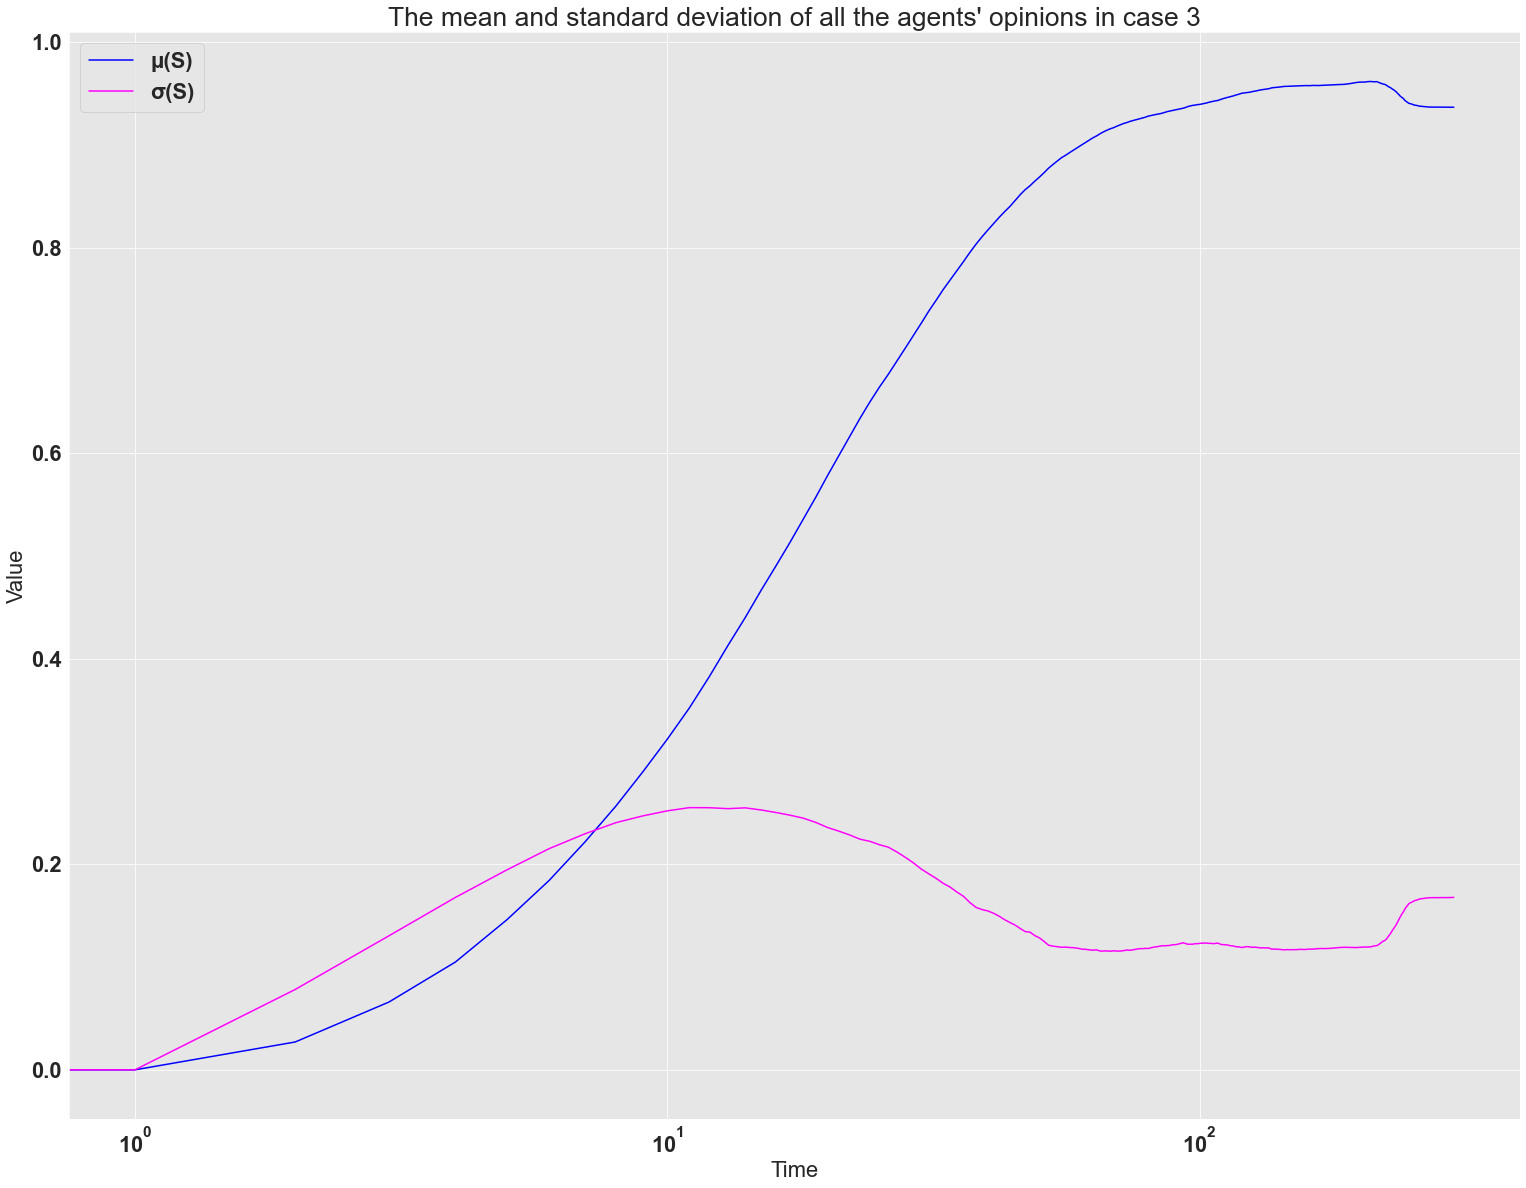

In [187]:
plt.figure()
plt.plot(range(0,T+1), k0_list, color = 'blue', label= "K=0")
plt.plot(range(0,T+1), k1_list, color = 'lime', label ="K=1")
plt.plot(range(0,T+1), k2_list, color = 'red', label ="K=2")
plt.xlabel("Time")
plt.ylabel("Average percent of agents of K_i")
plt.xscale("log")
plt.title("The percentage of each type of agents as a function of time, Case 3")
plt.legend(loc="best")
plt.savefig('The percentage of each type of agents as a function of time, Case 3.pdf')


plt.figure()
np.random.shuffle(k_matrix)
plt.imshow(k_matrix, interpolation='nearest', cmap='jet')
plt.xlabel("Time")
plt.ylabel("Agent index")
plt.title("All agents' evacuation status in case 3")
plt.colorbar()
plt.savefig("All agents' evacuation status in case 3.pdf")

plt.figure()
np.random.shuffle(S_matrix)
plt.imshow(S_matrix, interpolation='nearest', cmap='jet')
plt.xlabel("Time")
plt.ylabel("Agent index")
plt.title("All agents' opinion value in case 3")
plt.savefig("All agents' opinion value in case 3.pdf")
plt.colorbar()

plt.figure()
plt.plot(range(0,T+1), S_mean, color = 'blue', label = 'μ(S)')
plt.plot(range(0,T+1), S_std, color = 'magenta',label = 'σ(S)')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xscale('log')
plt.title("The mean and standard deviation of all the agents' opinions in case 3")
plt.legend(loc = "best")
plt.savefig("The mean and standard deviation of all the agents' opinions in case 3.pdf")
plt.show()

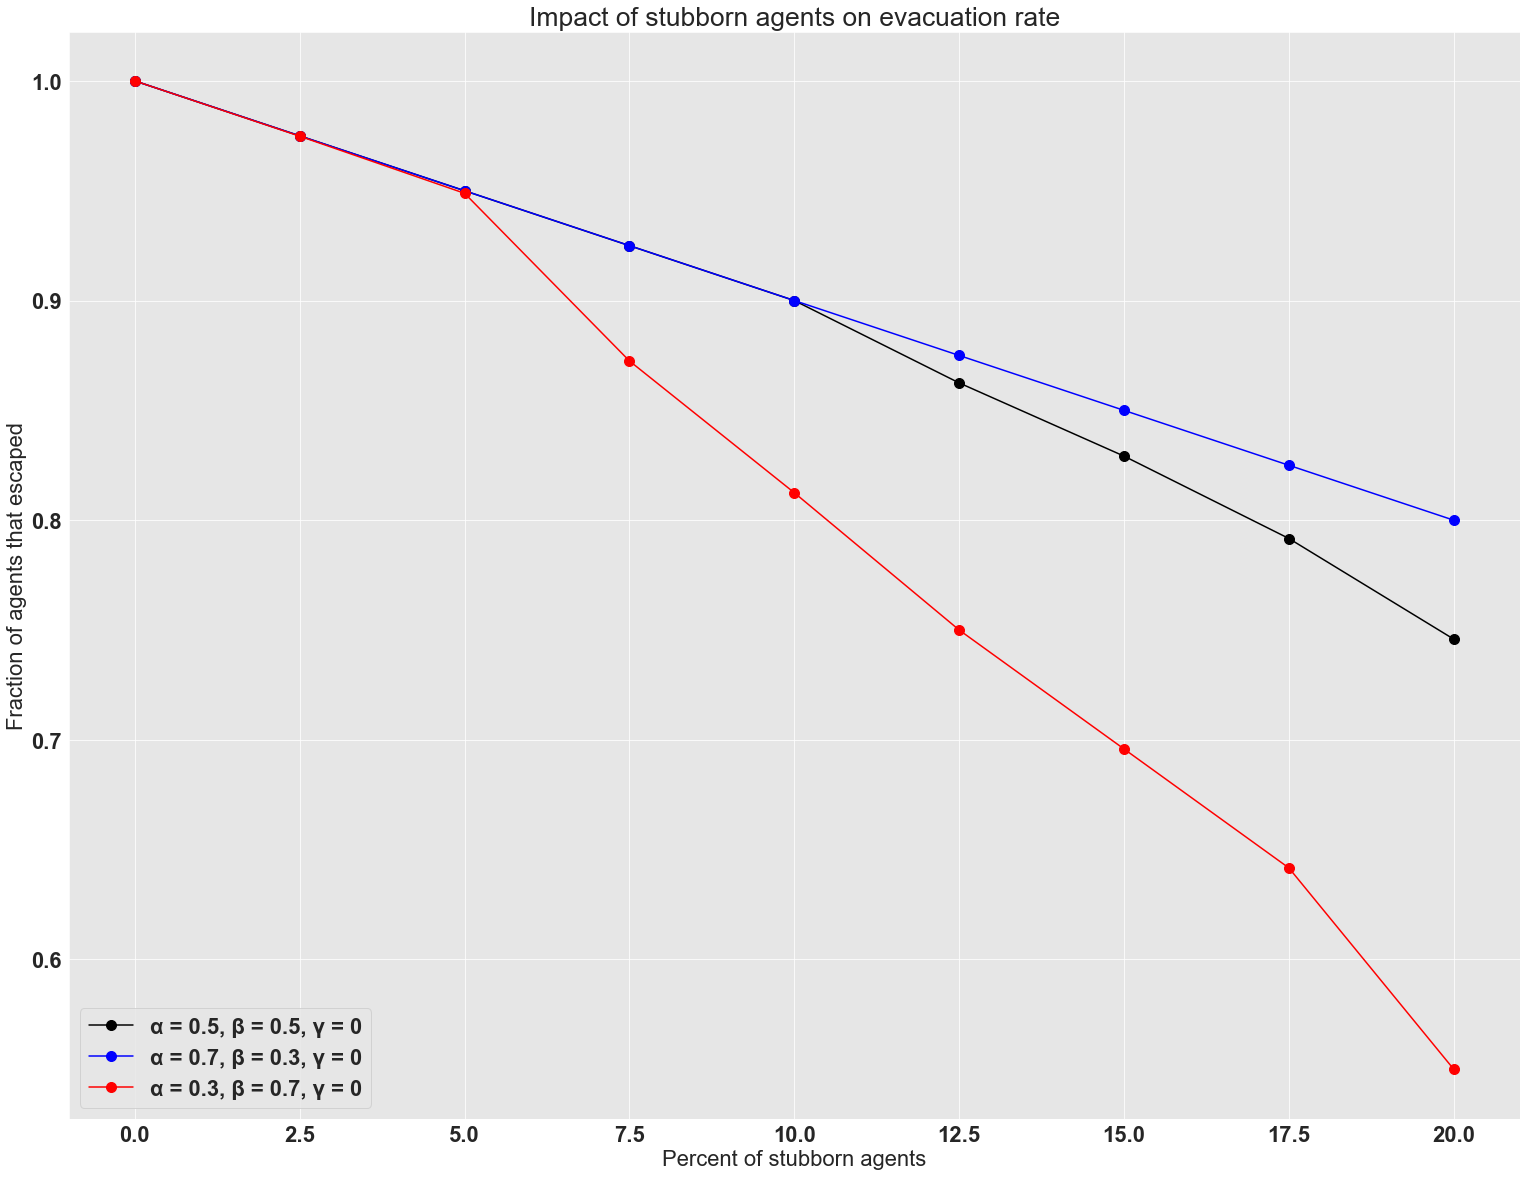

In [168]:
plt.figure()
plt.plot(percents, k2_list_general[0],'-o',markersize = 10, color = 'black', label = "α = 0.5, β = 0.5, γ = 0")
plt.plot(percents, k2_list_general[1],'-o',markersize = 10, color = 'blue', label = "α = 0.7, β = 0.3, γ = 0")
plt.plot(percents, k2_list_general[2],'-o',markersize = 10, color = 'red', label = "α = 0.3, β = 0.7, γ = 0")
plt.xlabel("Percent of stubborn agents")
plt.ylabel("Fraction of agents that escaped")
plt.title("Impact of stubborn agents on evacuation rate")
plt.legend(loc = 'lower left')
#plt.savefig("Impact of stubborn agents on evacuation rate.pdf")
plt.show()